In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x_disp = np.load('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient004_frame15_slice_6_ACDC_#0_x.npy')
y_disp = np.load('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient004_frame15_slice_6_ACDC_#0_y.npy')
frame1 = np.load('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient004_frame15_slice_6_ACDC_#0_1.npy')
# frame2 = np.load('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient006_frame16_slice_8_ACDC_#0_2.npy')

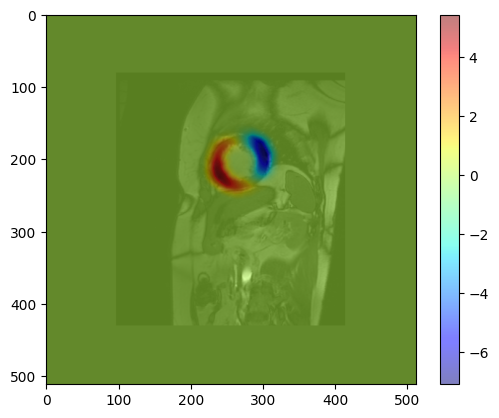

In [3]:
plt.imshow(frame1)
plt.imshow(x_disp, alpha=0.5, cmap='jet')
plt.colorbar()

In [4]:
def limit_strain_range(displacement_x, displacement_y, stretch, strain_upper_bound, 
                     reduction_factor=0.99, amplification_factor=1.01, max_iterations=1000, tolerance=1e-6):
    """
    Convert displacement maps to strain tensors using Eulerian strain formulation.
    Iteratively adjust displacements until all strain values are within the specified bounds:
    - Reduce displacements if strain exceeds upper bound
    - Amplify displacements if strain is below lower bound
    
    Parameters:
    -----------
    displacement_x : numpy.ndarray
        Displacement field in x-direction
    displacement_y : numpy.ndarray
        Displacement field in y-direction
    strain_lower_bound : float
        Minimum desired strain value
    strain_upper_bound : float
        Maximum allowable strain value
    reduction_factor : float, optional
        Factor by which to reduce displacements each iteration (default: 0.99)
    amplification_factor : float, optional
        Factor by which to amplify displacements each iteration (default: 1.01)
    max_iterations : int, optional
        Maximum number of iterations to perform (default: 1000)
    tolerance : float, optional
        Convergence tolerance (default: 1e-6)
    
    Returns:
    --------
    tuple
        (adjusted_displacement_x, adjusted_displacement_y, 
         initial_strain_tensor, final_strain_tensor, max_initial_strain, max_final_strain)
    """
    # Ensure input arrays have the same shape
    if displacement_x.shape != displacement_y.shape:
        raise ValueError("Displacement maps must have the same shape")
    if stretch:
        strain_lower_bound = 0.01
    else:
        strain_lower_bound = 0
    
    # Make copies of the input arrays to avoid modifying the originals
    dx = displacement_x.copy()
    dy = displacement_y.copy()

    # Create gradient operators for calculating spatial derivatives
    y_size, x_size = dx.shape
    
    # Calculate initial strain tensor
    # Calculate displacement gradients using central differences
    dudx_initial = np.zeros_like(dx)
    dudy_initial = np.zeros_like(dx)
    dvdx_initial = np.zeros_like(dx)
    dvdy_initial = np.zeros_like(dx)
    
    # Interior points (central differences)
    dudx_initial[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
    dudy_initial[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
    dvdx_initial[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
    dvdy_initial[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2
    
    # Edges (forward/backward differences)
    # Left edge
    dudx_initial[:, 0] = dx[:, 1] - dx[:, 0]
    dvdx_initial[:, 0] = dy[:, 1] - dy[:, 0]
    # Right edge
    dudx_initial[:, -1] = dx[:, -1] - dx[:, -2]
    dvdx_initial[:, -1] = dy[:, -1] - dy[:, -2]
    # Top edge
    dudy_initial[0, :] = dx[1, :] - dx[0, :]
    dvdy_initial[0, :] = dy[1, :] - dy[0, :]
    # Bottom edge
    dudy_initial[-1, :] = dx[-1, :] - dx[-2, :]
    dvdy_initial[-1, :] = dy[-1, :] - dy[-2, :]
    
    # Calculate Eulerian strain tensor components
    # E = 1/2 * (∇u + ∇u^T + ∇u^T∇u)
    E_xx_initial = 0.5 * (2*dudx_initial + dudx_initial**2 - dvdx_initial**2)
    E_yy_initial = 0.5 * (2*dvdy_initial + dudy_initial**2 - dvdy_initial**2)
    E_xy_initial = 0.5 * (dudy_initial + dvdx_initial - dudx_initial*dudy_initial - dvdx_initial*dvdy_initial)
    
    # Calculate principal strains
    avg_normal_strain_initial = (E_xx_initial + E_yy_initial) / 2
    diff_normal_strain_initial = (E_xx_initial - E_yy_initial) / 2
    radius_initial = np.sqrt(diff_normal_strain_initial**2 + E_xy_initial**2)
    
    E1_initial = avg_normal_strain_initial + radius_initial  # Maximum principal strain
    E2_initial = avg_normal_strain_initial - radius_initial  # Minimum principal strain

    E3_initial = 1 / ((1 + E1_initial) * (1 + E2_initial)) - 1
    
    # Find maximum and minimum absolute strain values
    max_initial_strain = max(np.max(np.abs(E1_initial)), np.max(np.abs(E2_initial)))
    min_initial_strain = min(np.min(np.abs(E1_initial)), np.min(np.abs(E2_initial)))
    
    # Store initial strain tensor
    initial_strain_tensor = {
        'E_xx': E_xx_initial,
        'E_yy': E_yy_initial,
        'E_xy': E_xy_initial,
        'E1': E1_initial,
        'E2': E2_initial,
        'E3': E3_initial,
        'min_abs_strain': min_initial_strain,
        'max_abs_strain': max_initial_strain
    }
    
    # If initial strain is already within bounds, no need to iterate
    if (max_initial_strain <= strain_upper_bound) and (min_initial_strain >= strain_lower_bound):
        return dx, dy, initial_strain_tensor, initial_strain_tensor, max_initial_strain, max_initial_strain, min_initial_strain, min_initial_strain
    
    # Otherwise, proceed with iterative adjustment
    iterations = 0
    max_strain = max_initial_strain
    min_strain = min_initial_strain
    prev_max_strain = float('inf')
    prev_min_strain = 0
    
    # Initialize strain tensor components for the loop
    E_xx = E_xx_initial.copy()
    E_yy = E_yy_initial.copy()
    E_xy = E_xy_initial.copy()
    E1 = E1_initial.copy()
    E2 = E2_initial.copy()
    
    while ((max_strain > strain_upper_bound) or (min_strain < strain_lower_bound)) and (iterations < max_iterations):
        # Determine whether to reduce or amplify displacements
        if max_strain > strain_upper_bound:
            # Reduce displacements if above upper bound
            adjustment_factor = reduction_factor
        elif min_strain < strain_lower_bound:
            # Amplify displacements if below lower bound
            adjustment_factor = amplification_factor
        else:
            # This shouldn't happen due to the while condition, but just in case
            break
        
        # Apply adjustment
        dx *= adjustment_factor
        dy *= adjustment_factor
        
        # Recalculate displacement gradients
        dudx = np.zeros_like(dx)
        dudy = np.zeros_like(dx)
        dvdx = np.zeros_like(dx)
        dvdy = np.zeros_like(dx)
        
        # Interior points (central differences)
        dudx[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
        dudy[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
        dvdx[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
        dvdy[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2
        
        # Edges (forward/backward differences)
        # Left edge
        dudx[:, 0] = dx[:, 1] - dx[:, 0]
        dvdx[:, 0] = dy[:, 1] - dy[:, 0]
        # Right edge
        dudx[:, -1] = dx[:, -1] - dx[:, -2]
        dvdx[:, -1] = dy[:, -1] - dy[:, -2]
        # Top edge
        dudy[0, :] = dx[1, :] - dx[0, :]
        dvdy[0, :] = dy[1, :] - dy[0, :]
        # Bottom edge
        dudy[-1, :] = dx[-1, :] - dx[-2, :]
        dvdy[-1, :] = dy[-1, :] - dy[-2, :]
        
        # Calculate Eulerian strain tensor components
        # E = 1/2 * (∇u + ∇u^T + ∇u^T∇u)
        E_xx = 0.5 * (2*dudx - dudx**2 - dvdx**2)
        E_yy = 0.5 * (2*dvdy - dudy**2 - dvdy**2)
        E_xy = 0.5 * (dudy + dvdx - dudx*dudy - dvdx*dvdy)
        
        # Calculate principal strains
        avg_normal_strain = (E_xx + E_yy) / 2
        diff_normal_strain = (E_xx - E_yy) / 2
        radius = np.sqrt(diff_normal_strain**2 + E_xy**2)
        
        E1 = avg_normal_strain + radius  # Maximum principal strain
        E2 = avg_normal_strain - radius  # Minimum principal strain
        E3 = 1 / ((1 + E1) * (1 + E2)) - 1
        
        # Find maximum and minimum absolute strain values
        max_strain = max(np.max(np.abs(E1)), np.max(np.abs(E2)))
        min_strain = min(np.min(np.abs(E1)), np.min(np.abs(E2)))
        
        # Check convergence
        if (abs(max_strain - prev_max_strain) < tolerance and 
            abs(min_strain - prev_min_strain) < tolerance):
            break
        
        prev_max_strain = max_strain
        prev_min_strain = min_strain
        iterations += 1
    
    # Prepare final strain tensor
    final_strain_tensor = {
        'E_xx': E_xx,
        'E_yy': E_yy,
        'E_xy': E_xy,
        'E1': E1,
        'E2': E2,
        'E3': E3,
        'min_abs_strain': min_strain,
        'max_abs_strain': max_strain
    }
    
    return dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain

In [5]:
dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = limit_strain_range(x_disp, y_disp, False, 1)

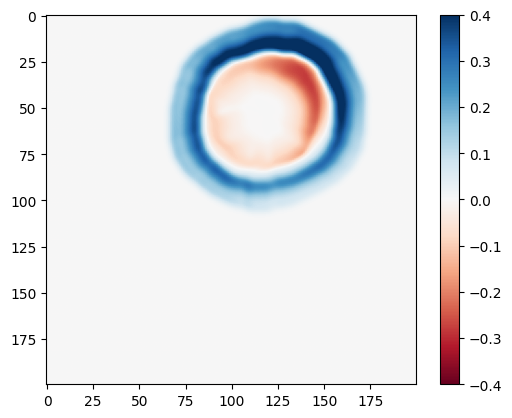

In [9]:
# plt.imshow(frame1[150:350, 150:350])
# plt.imshow(disp_mag[150:350, 150:350], cmap='jet', alpha=0.5)
plt.imshow(final_strain_tensor['E1'][150:350, 150:350], cmap='RdBu', vmin=-0.4, vmax=0.4, alpha=1)


plt.colorbar()
plt.show()

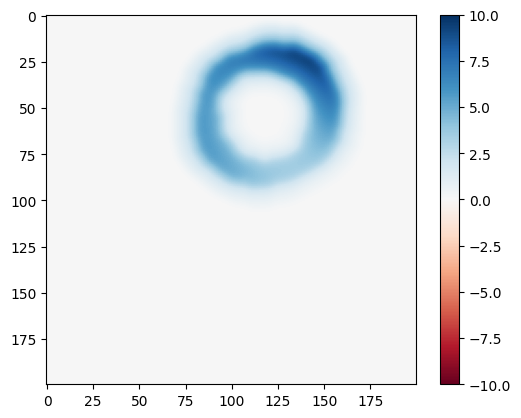

In [7]:
disp_mag = np.sqrt(x_disp**2 + y_disp**2)
# disp_mag = x_disp + y_disp
plt.imshow(disp_mag[150:350, 150:350], cmap='RdBu', vmin=-10, vmax=10)
plt.colorbar()
plt.show()

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_json_as_array_and_plot(filepath: str, cmap: str = 'gray', title: str = None) -> np.ndarray:
    """
    Loads a JSON file containing a serialized NumPy array,
    reconstructs the array, and plots it using imshow.

    Parameters:
        filepath (str): Path to the JSON file.
        cmap (str): Matplotlib colormap (default: 'gray').
        title (str): Optional title for the plot.

    Returns:
        np.ndarray: The reconstructed NumPy array.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    array = np.array(data)
    
    plt.imshow(array, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

    return array

# Example usage
_ =load_json_as_array_and_plot('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient034_frame16_slice_2_ACDC_#0_y.json', cmap='jet', title='My Plot')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient034_frame16_slice_2_ACDC_#0_y.json'

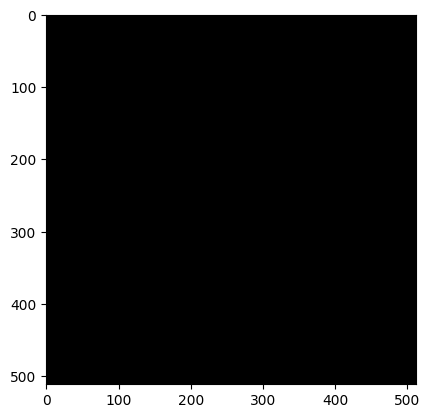

In [7]:
framex = np.load('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient014_frame13_slice_6_ACDC_#49_1.npy')
framey = np.load('/Users/osama/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient014_frame13_slice_6_ACDC_#52_1.npy')

plt.imshow(framex-framey)